When exploring a large set of documents -- such as Wikipedia, news articles, StackOverflow, etc. -- it can be useful to get a list of related material. To find relevant documents you typically
* Decide on a notion of similarity
* Find the documents that are most similar

In the assignment you will
* Gain intuition for different notions of similarity and practice finding similar documents.
* Explore the tradeoffs with representing documents using raw word counts and TF-IDF
* Explore the behavior of different distance metrics by looking at the Wikipedia pages most similar to President Obama’s page.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

## Load Wikipedia dataset

We will be using the dataset of abridged Wikipedia pages. Each element of the dataset consists of a link to the wikipedia article, the name of the person, and the text of the article (in lowercase).  

In [2]:
wiki = pd.read_csv('people_wiki.csv')
wiki.head()

,URI,name,text
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...
3,<http://dbpedia.org/resource/Franz_Rottensteiner>,Franz Rottensteiner,franz rottensteiner born in waidmannsfeld lowe...
4,<http://dbpedia.org/resource/G-Enka>,G-Enka,henry krvits born 30 december 1974 in tallinn ...


If you want to check whether the text on the webpage agrees with the one here, you can display it with the following code:

In [4]:
#from IPython.display import HTML
#print(wiki['text'][0])
#HTML(url=wiki['URI'][0])

## Ex. 1: Extract word count vectors

As we have seen in Assignment 4, we can extract word count vectors using `CountVectorizer` function.
- make sure you include words of unit length by using the parameter: `token_pattern=r"(?u)\b\w+\b"`
- do not use any stopwords
- take 10000 most frequent words in the corpus
- explicitly take all the words independent of in how many documents they occur
- obtain the matrix of word counts

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(token_pattern=r"(?u)\b\w+\b", max_features=10000, analyzer='word', min_df=1)
WCmatrix = vectorizer.fit_transform(wiki['text'])

print(vectorizer.get_feature_names_out())
print(WCmatrix.todense())

['0' '01' '1' ... 'zoology' 'zrich' 'zurich']
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


When initializing CountVectorizer, we need to specify the following parameters:


* *token_patter=r"(?u)* is a regular expression ensuring that we will include words of unit length.
* *analyzer='word'* is the default value of *analyzer* and is the required value when using *token_pattern*.
* *max_features=10000* will ensure that we take 10000 most frequent words in the corpus
* *min_df=1* is also the default value of *min_df* and sets what frequency or number of minimal occurrences in the text for a word to be used in the dictionary




We can learn about the most common words by using the Counter class

In [6]:
from collections import Counter

word_counts = WCmatrix.sum(axis=0)

word_counts_array = np.asarray(word_counts).reshape(-1)

feature_names = vectorizer.get_feature_names_out()

word_counts_dict = dict(zip(feature_names, word_counts_array))

top_10_words = Counter(word_counts_dict).most_common(10)

for word, count in top_10_words:
  print(f"{word}: {count}")

the: 1156479
in: 668317
and: 641587
of: 631290
a: 406426
he: 310487
to: 301421
was: 233234
for: 223928
as: 182483


## Ex. 2: Find nearest neighbors

**a)** Start by finding the nearest neighbors of the Barack Obama page using the above word count matrix to represent the articles and **Euclidean** distance to measure distance.
Save the distances in `wiki['BO-eucl']` and look at the top 10 nearest neighbors.

In [7]:
# One can use the following:
    # from sklearn.neighbors import NearestNeighbors
    # nbrs = NearestNeighbors(n_neighbors=3, algorithm='brute',metric='euclidean').fit(X.toarray())
    # distances, indices = nbrs.kneighbors(X.toarray())
# but here let's use:
from sklearn.metrics import pairwise_distances

obama_index = wiki[wiki['name'] == 'Barack Obama'].index[0]

dist = pairwise_distances(WCmatrix[obama_index], WCmatrix, metric='euclidean')
wiki['BO-eucl'] = dist[0]


The pairwise_distances function in scikit-learn computes the distances between all pairs of points in two datasets (or within a single dataset if one is provided). It supports various distance metrics (e.g., Euclidean, cosine, Manhattan), and returns a matrix where each entry represents the distance between a pair of points.

In [8]:
nearest_neighbors = wiki.sort_values('BO-eucl').iloc[:11]

nearest_neighbors

,URI,name,text,BO-eucl
35817,<http://dbpedia.org/resource/Barack_Obama>,Barack Obama,barack hussein obama ii brk husen bm born augu...,0.000000
24478,<http://dbpedia.org/resource/Joe_Biden>,Joe Biden,joseph robinette joe biden jr dosf rbnt badn b...,31.336879
28447,<http://dbpedia.org/resource/George_W._Bush>,George W. Bush,george walker bush born july 6 1946 is an amer...,33.645208
48202,<http://dbpedia.org/resource/Tony_Vaccaro>,Tony Vaccaro,michelantonio celestino onofrio vaccaro born d...,33.734256
14754,<http://dbpedia.org/resource/Mitt_Romney>,Mitt Romney,willard mitt romney born march 12 1947 is an a...,34.351128
31423,<http://dbpedia.org/resource/Walter_Mondale>,Walter Mondale,walter frederick fritz mondale born january 5 ...,34.423829
36364,<http://dbpedia.org/resource/Don_Bonker>,Don Bonker,don leroy bonker born march 7 1937 in denver c...,34.597688
13229,<http://dbpedia.org/resource/Francisco_Barrio>,Francisco Barrio,francisco javier barrio terrazas born november...,34.669872
35357,<http://dbpedia.org/resource/Lawrence_Summers>,Lawrence Summers,lawrence henry larry summers born november 30 ...,35.383612
25258,<http://dbpedia.org/resource/Marc_Ravalomanana>,Marc Ravalomanana,marc ravalomanana malagasy ravalumanan born 12...,35.440090


**b)** Measure the pairwise distance between the Wikipedia pages of Barack Obama, George W. Bush, and Joe Biden. Which of the three pairs has the smallest distance?

In [9]:
obama_index = wiki[wiki['name'] == 'Barack Obama'].index[0]
bush_index = wiki[wiki['name'] == 'George W. Bush'].index[0]
biden_index = wiki[wiki['name'] == 'Joe Biden'].index[0]

obama_bush_dist = pairwise_distances(WCmatrix[obama_index], WCmatrix[bush_index], metric='euclidean')[0][0]
obama_biden_dist = pairwise_distances(WCmatrix[obama_index], WCmatrix[biden_index], metric='euclidean')[0][0]
bush_biden_dist = pairwise_distances(WCmatrix[bush_index], WCmatrix[biden_index], metric='euclidean')[0][0]

print(f"Obama-Bush distance: {obama_bush_dist}")
print(f"Obama-Biden distance: {obama_biden_dist}")
print(f"Bush-Biden distance: {bush_biden_dist}")


Obama-Bush distance: 33.645207682521445
Obama-Biden distance: 31.336879231984796
Bush-Biden distance: 30.919249667480614


The smallest distance is in the Bush-Biden pairing.

All of the 10 people from **a)** are politicians, but about half of them have rather tenuous connections with Obama, other than the fact that they are politicians, e.g.,

* Francisco Barrio is a Mexican politician, and a former governor of Chihuahua.
* Walter Mondale and Don Bonker are Democrats who made their career in late 1970s.

Nearest neighbors with raw word counts got some things right, showing all politicians in the query result, but missed finer and important details.

**c)** Let's find out why Francisco Barrio was considered a close neighbor of Obama.
To do this, look at the most frequently used words in each of Barack Obama and Francisco Barrio's pages.

In [10]:
def top_words(name):
    """
    Get a table of the most frequent words in the given person's wikipedia page.
    """
    text = wiki[wiki['name'] == name]['text']
    PresonVectorizer = CountVectorizer(token_pattern=r"(?u)\b\w+\b", max_features=10000, analyzer='word', min_df=1)
    PersonMatrix = PresonVectorizer.fit_transform(text)

    word_counts = PersonMatrix.sum(axis=0)

    word_counts_array = np.asarray(word_counts).reshape(-1)

    feature_names = PresonVectorizer.get_feature_names_out()

    word_counts_dict = dict(zip(feature_names, word_counts_array))

    top_words = Counter(word_counts_dict).most_common()

    df = pd.DataFrame(top_words, columns=['word', 'count'])
    return df.sort_values(by='count',ascending=False)

In [11]:
obama_words = top_words('Barack Obama')
obama_words

,word,count
0,the,40
1,in,30
2,and,21
3,of,18
4,to,14
...,...,...
140,federal,1
141,filed,1
142,form,1
143,full,1


In [12]:
barrio_words = top_words('Francisco Barrio')
barrio_words

,word,count
0,the,36
1,of,24
2,and,18
3,in,17
4,he,10
...,...,...
104,favoritism,1
105,february,1
106,federal,1
107,fernando,1


Francisco Barrio is considered a close neighbor of Barack Obama due to the frequent occurrence of words such as “the” “in”, “and” etc. in both articles. These words indicate the similarity of the articles but are not precise enough to show the nature of the similarity.

**d)** Extract the list of most frequent **common** words that appear in both Obama's and Barrio's documents and display the five words that appear most often in Barrio's article.

Use a dataframe operation known as **join**. The **join** operation is very useful when it comes to playing around with data: it lets you combine the content of two tables using a shared column (in this case, the index column of words). See [the documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html) for more details.

In [13]:
common_words = obama_words.join(barrio_words.set_index('word'),
                                on='word', how='inner',
                                lsuffix='_Obama', rsuffix='_Barrio')
common_words.sort_values(by='count_Barrio', ascending=False).head(5)

,word,count_Obama,count_Barrio
0,the,40,36
3,of,18,24
2,and,21,18
1,in,30,17
9,he,7,10


Collect all words that appear both in Barack Obama and George W. Bush pages.  Out of those words, find the 10 words that show up most often in Obama's page.

In [36]:
bush_words = top_words('George W. Bush')
common_words2 = obama_words.join(bush_words.set_index('word'),
                                on='word', how='inner',
                                lsuffix='_Obama', rsuffix='_Bush',).sort_values(by='count_Obama', ascending=False)
common_words2.head(10)

,word,count_Obama,count_Bush
0,the,40,39
1,in,30,22
2,and,21,14
3,of,18,14
4,to,14,11
5,his,11,6
7,act,8,3
9,he,7,8
8,a,7,6
10,as,6,6


**Note.** Even though common words are swamping out important subtle differences, commonalities in rarer political words still matter on the margin. This is why politicians are being listed in the query result instead of musicians, for example. In the next subsection, we will introduce a different metric that will place greater emphasis on those rarer words.

**e)** Among the words that appear in both Barack Obama and Francisco Barrio, take the 15 that appear most frequently in Obama. How many of the articles in the Wikipedia dataset contain all of those 15 words? Which are they?

In [15]:
# It might be helpful to use:
word_to_ind={v: i for i, v in enumerate(vectorizer.get_feature_names_out())} # a dictionary with words as keys and indices as values

# Your code goes here
obama_mostf = common_words.sort_values(by='count_Obama', ascending=False).head(15)

matrix_indicies = [word_to_ind[word] for word in obama_mostf['word']]

subset_matrix = WCmatrix[:, matrix_indicies]

non_zero_rows = np.all(subset_matrix.toarray() != 0, axis=1)

articles = np.where(non_zero_rows)[0]

len(articles)

30

We get 30 articles containing all 15 words in common between articles about Barack Obama and Francisco Barrio. This is quite a large number, which should be a signal that our approach is not very precise

In [16]:
print(wiki.query(f"index == {articles.tolist()}")['name'])

1177                            Donald Fowler
1413                            Chris Redfern
3400                            James Bilbray
4004                              Paul Kagame
4874                            Bernard Kenny
6617                               Paul Sarlo
11316                Gy%C3%B6rgy Sur%C3%A1nyi
12371                         Morley Winograd
12743                 David Ibarra Mu%C3%B1oz
13229                        Francisco Barrio
16095    Charles Taylor (Liberian politician)
24417                           Jesse Ventura
24478                               Joe Biden
28447                          George W. Bush
29505                        Arturo Vallarino
33744                        John O. Agwunobi
35541                            Jimmy Carter
35817                            Barack Obama
36452                            Bill Clinton
38081                          John Garamendi
39489                          Helmut Anheier
40229                            E

## Ex. 3: TF-IDF to the rescue

Much of the perceived commonalities between Obama and Barrio were due to occurrences of extremely frequent words, such as "the", "and", and "his". So nearest neighbors is recommending plausible results sometimes for the wrong reasons.

To retrieve articles that are more relevant, we should focus more on rare words that don't happen in every article. **TF-IDF** (term frequency–inverse document frequency) is a feature representation that penalizes words that are too common.

**a)** Repeat the search for the 10 nearest neighbors of Barack Obama with Euclidean distance of TF-IDF. This time do not limit to only 10000 most frequent words, but take all of them.

In [17]:
# We could use:
    # from sklearn.feature_extraction.text import TfidfVectorizer
# but since we already know how to compute CountVectorizer, let's use:
from sklearn.feature_extraction.text import TfidfTransformer

vectorizer = CountVectorizer(token_pattern=r"(?u)\b\w+\b", analyzer='word', min_df=1)
WCmatrix=vectorizer.fit_transform(wiki['text'])

tfidf=TfidfTransformer(smooth_idf=False, norm=None)
TFIDFmatrix = tfidf.fit_transform(WCmatrix)

The TfidfTransformer in scikit-learn takes a matrix of word counts (often produced by CountVectorizer) and transforms it into a TF-IDF representation.

In [18]:
# now recompute the distances as before but for TF-IDF
dist = pairwise_distances(TFIDFmatrix[obama_index], TFIDFmatrix, metric='euclidean')
wiki['BO-eucl-TF-IDF'] = dist[0]


In [19]:
nearest_neighbors_TFIDF = wiki.sort_values('BO-eucl-TF-IDF').iloc[:11]

nearest_neighbors_TFIDF

,URI,name,text,BO-eucl,BO-eucl-TF-IDF
35817,<http://dbpedia.org/resource/Barack_Obama>,Barack Obama,barack hussein obama ii brk husen bm born augu...,0.000000,0.000000
38376,<http://dbpedia.org/resource/Samantha_Power>,Samantha Power,samantha power born september 21 1970 is an ir...,42.544095,139.364493
46811,<http://dbpedia.org/resource/Jeff_Sessions>,Jeff Sessions,jefferson beauregard jeff sessions iii born de...,46.518813,139.757740
7914,<http://dbpedia.org/resource/Phil_Schiliro>,Phil Schiliro,phil schiliro is an american political consult...,52.402290,139.812175
38714,<http://dbpedia.org/resource/Eric_Stern_(polit...,Eric Stern (politician),eric stern is the director of operations for t...,45.310043,140.450064
6507,<http://dbpedia.org/resource/Bob_Menendez>,Bob Menendez,robert bob menendez born january 1 1954 is the...,46.936127,141.661111
44681,<http://dbpedia.org/resource/Jesse_Lee_(politi...,Jesse Lee (politician),jesse lee born 1979 was named the white house ...,51.097945,142.342440
6796,<http://dbpedia.org/resource/Eric_Holder>,Eric Holder,eric himpton holder jr born january 21 1951 is...,47.106263,142.490179
38495,<http://dbpedia.org/resource/Barney_Frank>,Barney Frank,barnett barney frank born march 31 1940 is an ...,45.705580,142.581337
56008,<http://dbpedia.org/resource/Nathan_Cullen>,Nathan Cullen,nathan cullen mp born july 13 1972 is a canadi...,47.233463,142.751073


Let's determine whether this list makes sense.
* With a notable exception of Nathan Cullen, the other 8 are all American politicians who are contemporaries of Barack Obama.
* Phil Schiliro, Jesse Lee, Samantha Power, Eric Stern, Eric Holder worked for Obama.

Clearly, the results are more plausible with the use of TF-IDF. Let's take a look at the word vector for Obama and Schilirio's pages. Notice that TF-IDF representation assigns a weight to each word. This weight captures relative importance of that word in the document.

**b)** Sort the words in Obama's article by their TF-IDF weights; do the same for Schiliro's article as well.
Using the **join** operation we learned earlier, compute the common words shared by Obama's and Schiliro's articles.
Sort the common words by their TF-IDF weights in Obama's document.

In [20]:

def top_words_tf_idf(name):
    """
    Get a table of the largest tf-idf words in the given person's wikipedia page.
    """
    name_index = wiki[wiki['name'] == name].index[0]

    word_counts = TFIDFmatrix[name_index].sum(axis=0)

    word_counts_array = np.asarray(word_counts).reshape(-1)

    feature_names = vectorizer.get_feature_names_out()

    word_counts_dict = dict(zip(feature_names, word_counts_array))

    word_counts_dict = {word: tf_idf for word, tf_idf in word_counts_dict.items() if tf_idf > 0}

    top_words = Counter(word_counts_dict).most_common()


    df = pd.DataFrame(top_words, columns=['word', 'tf-idf'])
    return df.sort_values(by='tf-idf',ascending=False)

In [21]:
obama_tf_idf = top_words_tf_idf('Barack Obama')
schiliro_tf_idf = top_words_tf_idf('Phil Schiliro')


In [22]:
common_words = obama_tf_idf.join(schiliro_tf_idf.set_index('word'),
                                on='word', how='inner',
                                lsuffix='_Obama', rsuffix='_Schiliro')
common_words.head(15)

,word,tf-idf_Obama,tf-idf_Schiliro
0,obama,52.295653,11.621256
1,the,40.004063,10.001016
3,in,30.028962,5.004827
5,and,21.015648,6.004471
6,law,20.722936,10.361468
8,of,18.074811,9.037406
12,democratic,16.410689,8.205344
15,to,14.657229,7.328615
16,his,13.888726,1.262611
17,senate,13.164288,4.388096


We can see that in this case the common words are much more precise. Key words such as “democratic”, “president”, “2011” occur here. This means that our articles are not similar just because of the words in them, but we have managed to convey the meaning of the article

**c)** Among the words that appear in both Barack Obama and Phil Schiliro, take the 15 that have largest weights in Obama. How many of the articles in the Wikipedia dataset contain all of those 15 words? Which are they?

In [23]:
# It might be helpful to use:
word_to_ind={v: i for i, v in enumerate(vectorizer.get_feature_names_out())} # a dictionary with words as keys and indices as values

# Your code goes here
obama_mostf = common_words.sort_values(by='tf-idf_Obama', ascending=False).head(15)

matrix_indicies = [word_to_ind[word] for word in obama_mostf['word']]

subset_matrix = TFIDFmatrix[:, matrix_indicies]

non_zero_rows = np.all(subset_matrix.toarray() != 0, axis=1)

articles = np.where(non_zero_rows)[0]

len(articles)

3

We get 3 articles that contain each of 15 words. This means that we get more precision, and by looking at the given articles, we can actually say that their neighborhood seems sensible.

In [24]:
print(wiki.query(f"index == {articles.tolist()}")['name'])

7914     Phil Schiliro
24478        Joe Biden
35817     Barack Obama
Name: name, dtype: object


Notice the huge difference in this calculation using TF-IDF scores instead  of raw word counts. We've eliminated noise arising from extremely common words.

## Ex. 4: Choosing metrics

**a)** Compute the Euclidean distance between TF-IDF features of Obama and Biden.

In [25]:
obama_index = wiki[wiki['name'] == 'Barack Obama'].index[0]
biden_index = wiki[wiki['name'] == 'Joe Biden'].index[0]

dist = pairwise_distances(TFIDFmatrix[obama_index], TFIDFmatrix[biden_index], metric='euclidean')[0][0]
print(dist)

148.77845413077898


The distance is larger than the distances we found for the 10 nearest neighbors, which we repeat here for readability:

In [26]:
wiki.sort_values(by='BO-eucl-TF-IDF',ascending=True)[['name','BO-eucl-TF-IDF']][0:10]

,name,BO-eucl-TF-IDF
35817,Barack Obama,0.000000
38376,Samantha Power,139.364493
46811,Jeff Sessions,139.757740
7914,Phil Schiliro,139.812175
38714,Eric Stern (politician),140.450064
6507,Bob Menendez,141.661111
44681,Jesse Lee (politician),142.342440
6796,Eric Holder,142.490179
38495,Barney Frank,142.581337
56008,Nathan Cullen,142.751073


But one may wonder, is Biden's article that different from Obama's, more so than, say, Schiliro's? It turns out that, when we compute nearest neighbors using the Euclidean distances, we unwittingly favor short articles over long ones.

**b)** Let us compute the length of each Wikipedia document, and examine the document lengths for the 100 nearest neighbors to Obama's page. To compute text length use the same splitting rules you used in `vectorizer`.

In [27]:
tokenizer = lambda text : text.split()

def compute_length(row):
# Here we could use simply:
#     return len(row['text'].split(' '))
    return len(tokenizer(row['text']))

wiki['length'] = wiki.apply(compute_length, axis=1)

In [28]:
nearest_neighbors_euclidean = wiki[['name', 'length', 'BO-eucl-TF-IDF']].sort_values(by='BO-eucl-TF-IDF', ascending=True)[0:100]
nearest_neighbors_euclidean

,name,length,BO-eucl-TF-IDF
35817,Barack Obama,540,0.000000
38376,Samantha Power,310,139.364493
46811,Jeff Sessions,230,139.757740
7914,Phil Schiliro,208,139.812175
38714,Eric Stern (politician),255,140.450064
...,...,...,...
12834,Mark Waller (judge),211,146.796202
11303,Steven Weinberg,227,146.815087
8277,John M. Facciola,207,146.823495
11996,Thomas H. Jackson,216,146.836489


**c)** To see how these document lengths compare to the lengths of other documents in the corpus, make a histogram of the document lengths of Obama's 100 nearest neighbors and compare to a histogram of document lengths for all documents.

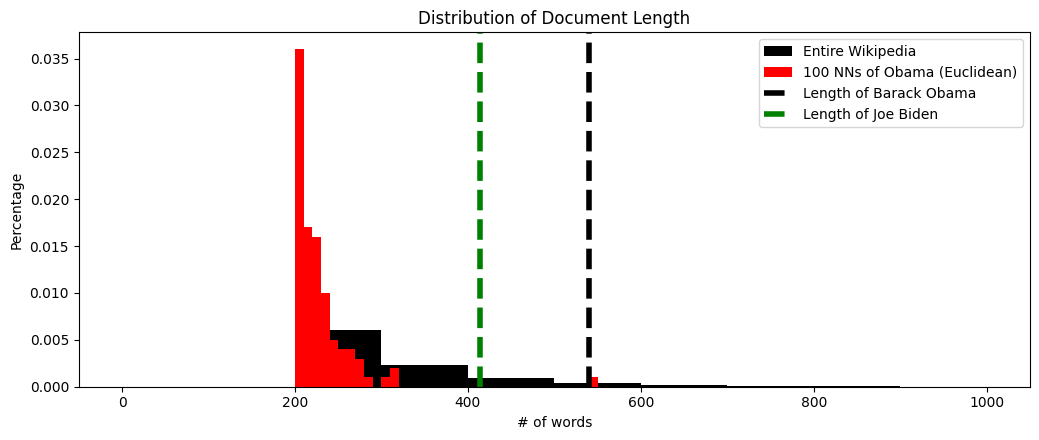

In [29]:
plt.figure(figsize=(10.5,4.5))
plt.hist(wiki['length'], color='black', alpha=1, range=(0,1000), density=True, label='Entire Wikipedia')
plt.hist(nearest_neighbors_euclidean['length'], bins=100, color='red', alpha=1, range=(0,1000), density=True, label='100 NNs of Obama (Euclidean)')

plt.axvline(wiki[wiki['name'] == 'Barack Obama']['length'].values[0], ls='--', color='black', label='Length of Barack Obama', linewidth=4)
plt.axvline(wiki[wiki['name'] == 'Joe Biden']['length'].values[0], ls='--', color='green', label='Length of Joe Biden', linewidth=4)

plt.xlabel("# of words")
plt.ylabel('Percentage')
plt.title("Distribution of Document Length")
plt.legend()
plt.tight_layout()

Relative to the rest of Wikipedia, nearest neighbors of Obama are overwhemingly short, most of them being shorter than 300 words. The bias towards short articles is not appropriate in this application as there is really no reason to  favor short articles over long articles (they are all Wikipedia articles, after all). Many of the Wikipedia articles are 300 words or more, and both Obama and Biden are over 300 words long.

**Note**: For the interest of computation time, the dataset given here contains _excerpts_ of the articles rather than full text. For instance, the actual Wikipedia article about Obama is around 25000 words. Do not be surprised by the low numbers shown in the histogram.

**Note:** Both word-count features and TF-IDF are proportional to word frequencies. While TF-IDF penalizes very common words, longer articles tend to have longer TF-IDF vectors simply because they have more words in them.

To remove this bias, we turn to **cosine distances**:
$$
d(\mathbf{x},\mathbf{y}) = 1 - \frac{\mathbf{x}^T\mathbf{y}}{\|\mathbf{x}\| \|\mathbf{y}\|}
$$
Cosine distances let us compare word distributions of two articles of varying lengths.

**d)** Train a new nearest neighbor model, this time with cosine distances.  Then repeat the search for Obama's 100 nearest neighbors and make a plot to better visualize the effect of having used cosine distance in place of Euclidean on our TF-IDF vectors.

In [30]:
dist = pairwise_distances(TFIDFmatrix[obama_index], TFIDFmatrix, metric='cosine')
wiki['BO-cos-TF-IDF'] = dist[0]
wiki['BO-cos-TF-IDF'] = wiki['BO-cos-TF-IDF'].apply(lambda x : f'{x:.6f}')
nearest_neighbors_cosine = wiki[['name', 'length', 'BO-cos-TF-IDF']].sort_values(by='BO-cos-TF-IDF', ascending=True)[0:100]
nearest_neighbors_cosine

,name,length,BO-cos-TF-IDF
35817,Barack Obama,540,0.000000
24478,Joe Biden,414,0.572725
57108,Hillary Rodham Clinton,580,0.616149
38376,Samantha Power,310,0.625797
38714,Eric Stern (politician),255,0.651475
...,...,...,...
2045,Allan Ryan (attorney),291,0.731376
47085,Ray Thornton,326,0.731908
16392,P%C3%A9ter Kov%C3%A1cs (lawyer),365,0.732172
55495,Lokman Singh Karki,2486,0.732608


From a glance at the above table, things look better.  For example, we now see Joe Biden as Barack Obama's nearest neighbor!  We also see Hillary Clinton on the list.  This list looks even more plausible as nearest neighbors of Barack Obama.

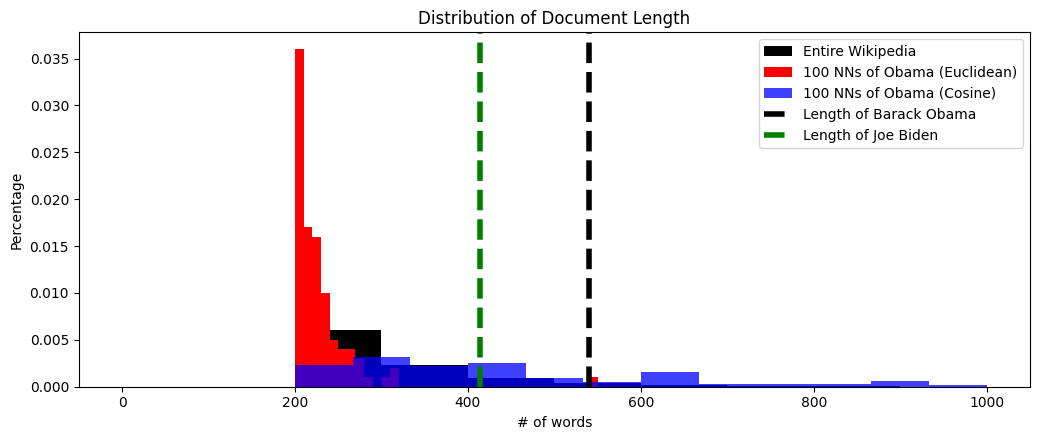

In [31]:
plt.figure(figsize=(10.5,4.5))
plt.hist(wiki['length'], color='black', alpha=1, range=(0,1000), density=True, label='Entire Wikipedia')
plt.hist(nearest_neighbors_euclidean['length'], bins=100, color='red', alpha=1, range=(0,1000), density=True, label='100 NNs of Obama (Euclidean)')
plt.hist(nearest_neighbors_cosine['length'],  bins=15, color='blue', alpha=0.75, range=(0,1000), density=True, label='100 NNs of Obama (Cosine)')

plt.axvline(wiki[wiki['name'] == 'Barack Obama']['length'].values[0], ls='--', color='black', label='Length of Barack Obama', linewidth=4)
plt.axvline(wiki[wiki['name'] == 'Joe Biden']['length'].values[0], ls='--', color='green', label='Length of Joe Biden', linewidth=4)

plt.xlabel("# of words")
plt.ylabel('Percentage')
plt.title("Distribution of Document Length")
plt.legend()
plt.tight_layout()

Indeed, the 100 nearest neighbors using cosine distance provide a sampling across the range of document lengths, rather than just short articles like Euclidean distance provided.

**Moral of the story**: In deciding the features and distance measures, check if they produce results that make sense for your particular application.

## Ex. 5: Problem with cosine distances: tweets vs. long articles

Happily ever after? Not so fast. Cosine distances ignore all document lengths, which may be great in certain situations but not in others. For instance, consider the following (admittedly contrived) example.

```
+--------------------------------------------------------+
|                                             +--------+ |
|  One that shall not be named                | Follow | |
|  @username                                  +--------+ |
|                                                        |
|  Democratic governments control law in response to     |
|  popular act.                                          |
|                                                        |
|  8:05 AM - 16 May 2016                                 |
|                                                        |
|  Reply   Retweet (1,332)   Like (300)                  |
|                                                        |
+--------------------------------------------------------+
```

**a)** Transform the tweet into TF-IDF features, using the fit to the Wikipedia dataset. (That is, let's treat this tweet as an article in our Wikipedia dataset and see what happens.) How similar is this tweet to Barack Obama's Wikipedia article?

In [32]:
df = pd.DataFrame({'text': ['democratic governments control law in response to popular act']})

tweet_tfidf = tfidf.transform(vectorizer.transform(df['text']))
feature_names = vectorizer.get_feature_names_out()
tweet_tfidf_array = tweet_tfidf.toarray()[0]

tweet_data = []
for i, tfidf_val in enumerate(tweet_tfidf_array):
    if tfidf_val > 0:
        tweet_data.append({'word': feature_names[i], 'count': 1, 'tf-idf': tfidf_val})


tweet_tfidf_df = pd.DataFrame(tweet_data)
tweet_tfidf_df

,word,count,tf-idf
0,act,1,4.459778
1,control,1,4.721765
2,democratic,1,4.102672
3,governments,1,5.167571
4,in,1,1.000965
5,law,1,3.453823
6,popular,1,3.764479
7,response,1,5.261462
8,to,1,1.046945


Let's compare this tweet's TF-IDF vectors  to Barack Obama's Wikipedia entry.

In [33]:
obama_tf_idf

,word,tf-idf
0,obama,52.295653
1,the,40.004063
2,act,35.678223
3,in,30.028962
4,iraq,21.747379
...,...,...
268,is,2.055233
269,new,1.887235
270,which,1.767431
271,that,1.661407


**b)** Now, compute the cosine distance between the Barack Obama article and this tweet:

In [34]:
from sklearn.metrics.pairwise import cosine_distances

tweet_tfidf = tfidf.transform(vectorizer.transform(df['text']))
distance = cosine_distances(TFIDFmatrix[obama_index], tweet_tfidf)
print(f"Cosine distance between the Barack Obama article and this tweet:\n{distance}")

Cosine distance between the Barack Obama article and this tweet:
[[0.69866453]]


Let's compare this distance to the distance between the Barack Obama article and all of its Wikipedia nearest neighbors:

In [35]:
nearest_neighbors_cosine[0:23]

,name,length,BO-cos-TF-IDF
35817,Barack Obama,540,0.000000
24478,Joe Biden,414,0.572725
57108,Hillary Rodham Clinton,580,0.616149
38376,Samantha Power,310,0.625797
38714,Eric Stern (politician),255,0.651475
28447,George W. Bush,505,0.659478
39357,John McCain,410,0.661645
48693,Artur Davis,371,0.666690
18827,Henry Waxman,279,0.671226
37199,Barry Sullivan (lawyer),893,0.673300


With cosine distances, the tweet is "nearer" to Barack Obama than most people! If someone is reading the Barack Obama Wikipedia page, would you want to recommend they read this tweet?
In practice, it is common to enforce maximum or minimum document lengths. After all, when someone is reading a long article from _The Atlantic_, you wouldn't recommend him/her a tweet.